In [24]:
import pandas as pd

# Load the events dataset
data = pd.read_csv('C:/Users/nafla/Downloads/article/dataset/events.csv', dtype={'visitorid': int, 'event': str, 'itemid': int})
data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')  # Convert from Unix time in milliseconds


In [25]:
data.head()

,timestamp,visitorid,event,itemid,transactionid
0,2015-06-02 05:02:12.117,257597,view,355908,NaN
1,2015-06-02 05:50:14.164,992329,view,248676,NaN
2,2015-06-02 05:13:19.827,111016,view,318965,NaN
3,2015-06-02 05:12:35.914,483717,view,253185,NaN
4,2015-06-02 05:02:17.106,951259,view,367447,NaN


In [26]:
# Sort the data by visitorid and timestamp
data.sort_values(by=['visitorid', 'timestamp'], inplace=True)

# Define a session threshold (e.g., 30 minutes)
session_threshold = pd.Timedelta(minutes=30)

# Calculate time differences between user activities
data['time_diff'] = data.groupby('visitorid')['timestamp'].diff()

# Identify where new sessions should start
data['new_session'] = (data['time_diff'] > session_threshold).astype(int)

# Cumulatively sum the new_session flags to create unique session IDs per user
data['session_id'] = data.groupby('visitorid')['new_session'].cumsum()

# Create a global unique session identifier across all users
data['global_session_id'] = data['visitorid'].astype(str) + '_' + data['session_id'].astype(str)


In [27]:
# Find the start time of each session
data['session_start'] = data.groupby('global_session_id')['timestamp'].transform('min')

# Calculate the time since the start of the session
data['time_since_session_start'] = (data['timestamp'] - data['session_start']).dt.total_seconds()


In [28]:
# Drop temporary columns to clean up the DataFrame
data.drop(columns=['time_diff', 'new_session', 'session_start', 'transactionid'], inplace=True)
data.head()

,timestamp,visitorid,event,itemid,session_id,global_session_id,time_since_session_start
1361687,2015-09-11 20:49:49.439,0,view,285930,0,0_0,0.000
1367212,2015-09-11 20:52:39.591,0,view,357564,0,0_0,170.152
1367342,2015-09-11 20:55:17.175,0,view,67045,0,0_0,327.736
830385,2015-08-13 17:46:06.444,1,view,72028,0,1_0,0.000
742616,2015-08-07 17:51:44.567,2,view,325215,0,2_0,0.000


In [29]:
# Assuming 'data' is your DataFrame with the sessionized event data
data = pd.get_dummies(data, columns=['event'], prefix='', prefix_sep='')
data.head()

,timestamp,visitorid,itemid,session_id,global_session_id,time_since_session_start,addtocart,transaction,view
1361687,2015-09-11 20:49:49.439,0,285930,0,0_0,0.000,False,False,True
1367212,2015-09-11 20:52:39.591,0,357564,0,0_0,170.152,False,False,True
1367342,2015-09-11 20:55:17.175,0,67045,0,0_0,327.736,False,False,True
830385,2015-08-13 17:46:06.444,1,72028,0,1_0,0.000,False,False,True
742616,2015-08-07 17:51:44.567,2,325215,0,2_0,0.000,False,False,True


In [30]:
# Calculating the number of unique values in each column
unique_counts = data.nunique()

# Calculating the number of missing values in each column
missing_counts = data.isnull().sum()

# Combining both information into a single DataFrame for better visualization
summary_df = pd.DataFrame({
    'Unique Counts': unique_counts,
    'Missing Counts': missing_counts
})

# Display the summary DataFrame
print(summary_df)

                          Unique Counts  Missing Counts
timestamp                       2750455               0
visitorid                       1407580               0
itemid                           235061               0
session_id                          462               0
global_session_id               1761675               0
time_since_session_start         651148               0
addtocart                             2               0
transaction                           2               0
view                                  2               0


In [31]:
# Calculate the number of events in each session
session_lengths = data.groupby('global_session_id').size()

c:\Users\nafla\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


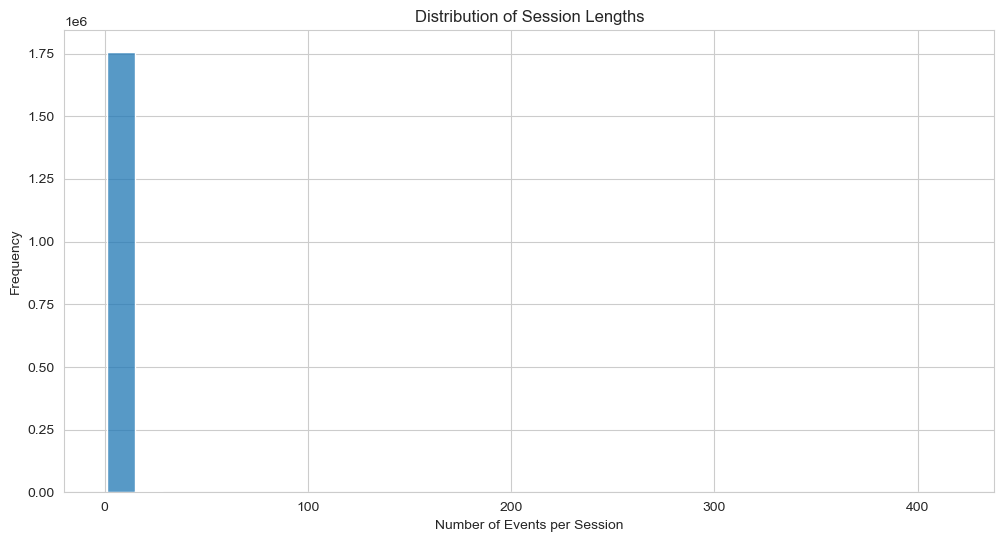

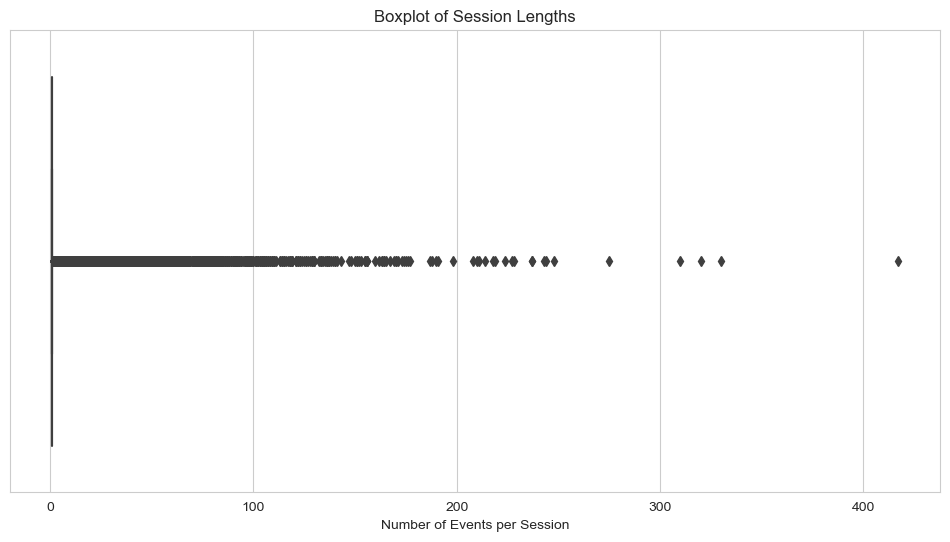

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Plot histogram of session lengths
plt.figure(figsize=(12, 6))
sns.histplot(session_lengths, bins=30, kde=False)
plt.title('Distribution of Session Lengths')
plt.xlabel('Number of Events per Session')
plt.ylabel('Frequency')
plt.show()

# Plot boxplot to see the distribution and identify potential outliers
plt.figure(figsize=(12, 6))
sns.boxplot(x=session_lengths)
plt.title('Boxplot of Session Lengths')
plt.xlabel('Number of Events per Session')
plt.show()


In [44]:
# Filter session_lengths to find those sessions where the number of events is greater than 200
sessions_over_200 = session_lengths[session_lengths > 5]

# Count the number of sessions with more than 200 events
number_of_sessions_over_200 = sessions_over_200.count()

print(f"Number of sessions with more than 200 events: {number_of_sessions_over_200}")


Number of sessions with more than 200 events: 44141


In [45]:
# Filter to find sessions with more than 1 and less than 5 events
filtered_session_ids = session_lengths[(session_lengths > 1) & (session_lengths < 5)].index

In [46]:
# Filter the original data to keep only the sessions of interest
filtered_data = data[data['global_session_id'].isin(filtered_session_ids)]

# Optional: Verify the results
print(filtered_data.head())
print(f"Number of sessions retained: {filtered_data['global_session_id'].nunique()}")


                      timestamp  visitorid  itemid  session_id  \
1361687 2015-09-11 20:49:49.439          0  285930           0   
1367212 2015-09-11 20:52:39.591          0  357564           0   
1367342 2015-09-11 20:55:17.175          0   67045           0   
1135980 2015-08-30 06:39:38.318          6  253615           1   
1130136 2015-08-30 06:40:23.805          6  344723           1   

        global_session_id  time_since_session_start  addtocart  transaction  \
1361687               0_0                     0.000      False        False   
1367212               0_0                   170.152      False        False   
1367342               0_0                   327.736      False        False   
1135980               6_1                     0.000      False        False   
1130136               6_1                    45.487      False        False   

         view  
1361687  True  
1367212  True  
1367342  True  
1135980  True  
1130136  True  
Number of sessions retained: 319

In [48]:
filtered_data.info

<bound method DataFrame.info of                       timestamp  visitorid  itemid  session_id  \
1361687 2015-09-11 20:49:49.439          0  285930           0   
1367212 2015-09-11 20:52:39.591          0  357564           0   
1367342 2015-09-11 20:55:17.175          0   67045           0   
1135980 2015-08-30 06:39:38.318          6  253615           1   
1130136 2015-08-30 06:40:23.805          6  344723           1   
...                         ...        ...     ...         ...   
2642325 2015-07-27 05:13:15.037    1407573   57720           1   
2755781 2015-08-01 04:12:07.230    1407573  363109           2   
2742528 2015-08-01 04:12:45.311    1407573  463766           2   
656195  2015-08-04 00:32:47.715    1407573   82278           3   
645052  2015-08-04 00:34:55.146    1407573   82278           3   

        global_session_id  time_since_session_start  addtocart  transaction  \
1361687               0_0                     0.000      False        False   
1367212          

In [50]:
# Example: Save the filtered data to a new CSV file
filtered_data.to_csv('C:/Users/nafla/Downloads/article/dataset/filtered_sessions.csv', index=False)